<a href="https://colab.research.google.com/github/FBehrad/AI-in-medical-field/blob/main/Preprocess_medical_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Install required packages

In [ ]:
!pip install SimpleITK # for reading and showing medical images
!pip install nipype # for preprocessing
!pip install pyradiomics # required package for extracting radiomics features

     |████████████████████████████████| 48.4 MB 5.1 kB/s 
     |████████████████████████████████| 3.2 MB 14.1 MB/s 
     |████████████████████████████████| 5.1 MB 43.9 MB/s 
     |████████████████████████████████| 129 kB 50.0 MB/s 
     |████████████████████████████████| 421 kB 47.8 MB/s 
     |████████████████████████████████| 407 kB 52.4 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 188 kB 16.6 MB/s 
     |████████████████████████████████| 109 kB 56.6 MB/s 
     |████████████████████████████████| 546 kB 55.0 MB/s 


3. Import required libraries

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import nibabel as nib
from scipy import ndimage
import glob  # For retrieving files/pathnames matching a specified pattern
import re # specifies a set of strings that matches it
import SimpleITK as sitk # important package for medical imaging
import zipfile  
import six
from skimage.exposure import histogram
from skimage.util import img_as_ubyte
from skimage import exposure, util
from radiomics import featureextractor

4. Extract dataset

In [ ]:
def extract_dataset(addr, target):
  dataset_path = addr 
  zfile = zipfile.ZipFile(dataset_path)
  zfile.extractall(target)

In [ ]:
extract_dataset('/content/drive/MyDrive/MICCAI_BraTS_2018_Data_Training.zip','Training') # Replace with your dataset path

In [ ]:
t1 = glob.glob('/content/Training/*GG/*/*t1.nii.gz')
t2 = glob.glob('/content/Training/*GG/*/*t2.nii.gz')
flair = glob.glob('/content/Training/*GG/*/*flair.nii.gz')
t1ce = glob.glob('/content/Training/*GG/*/*t1ce.nii.gz')
seg = glob.glob('/content/Training/*GG/*/*seg.nii.gz')  # Ground Truth
pattern = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pattern.findall(item)[0]:item for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

# print(data_paths)
print('number of training examples' ,len(data_paths))


number of training examples 285


5. Read image

In [ ]:
def read_img_sitk(img_path):
    image_data = sitk.ReadImage(img_path)
    return image_data 

6. Extract centre of the tumor

In [ ]:
def centre_of_tumor(input_image,input_mask):
  extractor = featureextractor.RadiomicsFeatureExtractor()
  extractor.disableAllFeatures()
  result = extractor.execute(input_image,input_mask)
  print(result)
  centre_of_mass = []
  for key, value in six.iteritems(result):
    if key == 'diagnostics_Mask-original_CenterOfMassIndex':
      centre_of_mass.append(value[0])
      centre_of_mass.append(value[1])
      centre_of_mass.append(value[2]) 
  return centre_of_mass

In [ ]:
img = read_img_sitk(data_paths[30]['flair'])
mask = read_img_sitk(data_paths[30]['seg'])
centre = centre_of_tumor(img,mask)
print('Centre of mass :', centre)

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'), ('diagnostics_Versions_Numpy', '1.19.5'), ('diagnostics_Versions_SimpleITK', '2.1.1'), ('diagnostics_Versions_PyWavelet', '1.1.1'), ('diagnostics_Versions_Python', '3.7.12'), ('diagnostics_Configuration_Settings', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}), ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}), ('diagnostics_Image-original_Hash', 'a5623ad60f390bf2ae9b9875584923f4f856324a'), ('diagnostics_Image-original_Dimensionality', '3D'), ('diagnostics_Image-original_Spacing', (1.0, 1.0, 1.0)), ('diagnostics_Image-original_Size', (240, 240, 155)), ('diagnostics_Image-original_Mean', 89.97697703853046), ('diagnostics_Image-o

7. Crop images

In [ ]:
def crop_images(img,centre_of_mass,optimal_roi,image_size):
  
  x_roi = round(optimal_roi[0]/2)
  y_roi = round(optimal_roi[1]/2)
  z_roi = round(optimal_roi[2]/2)
  x_centre = round(centre_of_mass[0])
  y_centre = round(centre_of_mass[1])
  z_centre= round(centre_of_mass[2])

  if x_centre - x_roi< 0:
    start_x = 0 
    end_x = optimal_roi[0]
  elif x_centre + x_roi >= image_size[0]:
    end_x = image_size[0] - 1
    start_x = end_x - optimal_roi[0]
  else:
    start_x = x_centre - x_roi
    end_x =  x_centre + x_roi

  if y_centre - y_roi< 0:
    start_y = 0 
    end_y = optimal_roi[1]
  elif y_centre + y_roi >= image_size[1]:
    end_y = image_size[1] - 1
    start_y = end_y - optimal_roi[1]
  else:
    start_y = y_centre - y_roi
    end_y =  y_centre + y_roi

  if z_centre - z_roi< 0:
    start_z = 0 
    end_z = optimal_roi[2]
  elif z_centre + z_roi >= image_size[2]:
    end_z = image_size[2] - 1
    start_z = end_z - optimal_roi[2]
  else:
    start_z = z_centre - z_roi
    end_z =  z_centre + z_roi

  cropped_img = img[start_x:end_x,
                    start_y:end_y,
                    start_z:end_z] 
  return cropped_img

In [ ]:
optimal_roi = [128,128,128]
image_size = [240,240,155]
croped_img = crop_images(img,centre,optimal_roi,image_size)
croped_mask = crop_images(mask,centre,optimal_roi,image_size)

Lets check the results

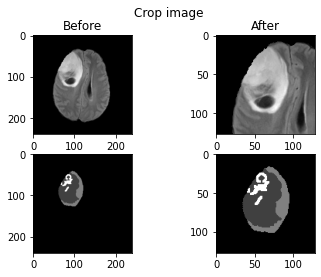

In [ ]:
fig, ax = plt.subplots(2, 2)
fig.suptitle("Crop image")
ax[0,0].set_title('Before')
ax[0,0].imshow(sitk.GetArrayViewFromImage(img)[90,:,:], cmap='gray')
ax[0,1].set_title('After')
ax[0,1].imshow(sitk.GetArrayViewFromImage(croped_img)[64,:,:], cmap='gray')
ax[1,0].imshow(sitk.GetArrayViewFromImage(mask)[90,:,:], cmap='gray')
ax[1,1].imshow(sitk.GetArrayViewFromImage(croped_mask)[64,:,:], cmap='gray')

7. Plot histogram

In [ ]:
img1 = read_img_sitk(data_paths[20]['flair'])
img2 = read_img_sitk(data_paths[24]['flair'])

(0.01, 2000.0, 0.0, 20000.0)

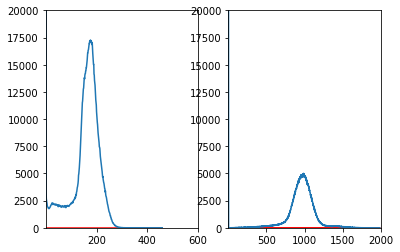

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
img1_array = sitk.GetArrayFromImage(img1)
img2_array = sitk.GetArrayFromImage(img2)
hist1, hist_centers1 = histogram(img1_array,nbins=256)
img_cdf1, bins1 = exposure.cumulative_distribution(img1_array)
hist2, hist_centers2 = histogram(img2_array,nbins=256)
img_cdf2, bins2 = exposure.cumulative_distribution(img2_array)
ax1.plot(bins1, img_cdf1, 'r')
ax1.plot(hist_centers1, hist1)
ax2.plot(bins2, img_cdf2, 'r')
ax2.plot(hist_centers2, hist2)
ax1.axis([0.01, 600, 0, 2e4])
ax2.axis([0.01, 2000, 0, 2e4])

8. Rescale image

In [ ]:
def rescale_image(image):
  filter = sitk.RescaleIntensityImageFilter()
  filter.SetOutputMaximum(255)
  filter.SetOutputMinimum(0)
  rescaled_img = filter.Execute(image)
  return rescaled_img

In [ ]:
rescaled_img = rescale_image(croped_img)
rescaled_img1 = rescale_image(img1)
rescaled_img2 = rescale_image(img2)

(0.01, 300.0, 0.0, 100000.0)

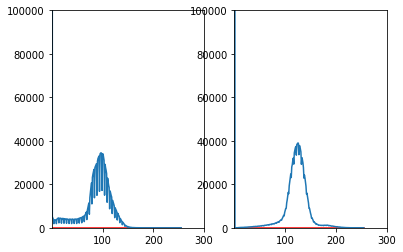

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
rescaled_img1_array = sitk.GetArrayFromImage(rescaled_img1)
rescaled_img2_array = sitk.GetArrayFromImage(rescaled_img2)
hist1, hist_centers1 = histogram(rescaled_img1_array,nbins=256)
img_cdf1, bins1 = exposure.cumulative_distribution(rescaled_img1_array)
hist2, hist_centers2 = histogram(rescaled_img2_array,nbins=256)
img_cdf2, bins2 = exposure.cumulative_distribution(rescaled_img2_array)
ax1.plot(bins1, img_cdf1, 'r')
ax1.plot(hist_centers1, hist1)
ax2.plot(bins2, img_cdf2, 'r')
ax2.plot(hist_centers2, hist2)
ax1.axis([0.01, 300, 0, 1e5])
ax2.axis([0.01, 300, 0, 1e5])

9. Normalization

In [ ]:
def mean_normalization(image):
  image = sitk.GetArrayFromImage(image)
  mask = np.where(image != 0)
  desired_img = image[mask]
  mean = np.mean(desired_img)
  std = np.std(desired_img)
  final_image = (image - mean)/ std
  final_image = sitk.GetImageFromArray(final_image)
  return final_image

In [ ]:
def max_min_normalization(image):
  image = sitk.GetArrayFromImage(image)
  max = np.max(image)
  min = np.min(image)
  final_image = (image - min)/ (max - min)
  final_image = sitk.GetImageFromArray(final_image)
  return final_image

In [ ]:
rescaled_img = rescale_image(croped_img)

In [ ]:
mm_normalized_image = max_min_normalization(rescaled_img)
m_normalized_image = mean_normalization(rescaled_img)

(-3.0, 5.0, 0.0, 20000.0)

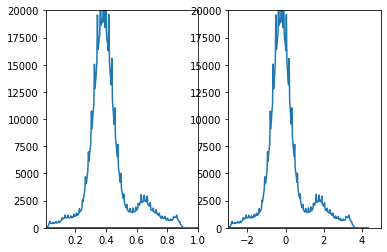

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2)
mm_array = sitk.GetArrayFromImage(mm_normalized_image)
m_array = sitk.GetArrayFromImage(m_normalized_image)
hist1, hist_centers1 = histogram(mm_array,nbins=256)
img_cdf1, bins1 = exposure.cumulative_distribution(mm_array)
hist2, hist_centers2 = histogram(m_array,nbins=256)
img_cdf2, bins2 = exposure.cumulative_distribution(m_array)
ax1.plot(bins1, img_cdf1, 'r')
ax1.plot(hist_centers1, hist1)
ax2.plot(bins2, img_cdf2, 'r')
ax2.plot(hist_centers2, hist2)
ax1.axis([0.01, 1, 0, 2e4])
ax2.axis([-3, 5, 0, 2e4])

10. Bias Correction

In [ ]:
def n4_bias_correction(image):
  image = sitk.Cast(image,sitk.sitkFloat32)
  corrector = sitk.N4BiasFieldCorrectionImageFilter()
  output_corrected = corrector.Execute(image)
  return output_corrected

In [ ]:
bias_corrected_img = n4_bias_correction(m_normalized_image)

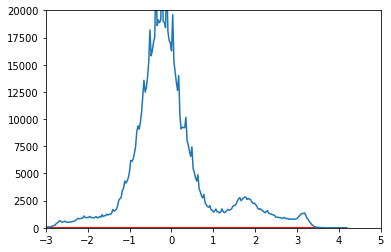

In [ ]:
bias_corrected_img_array = sitk.GetArrayFromImage(bias_corrected_img)
hist, hist_centers = histogram(bias_corrected_img_array,nbins=256)
img_cdf, bins = exposure.cumulative_distribution(bias_corrected_img_array)
plt.plot(bins, img_cdf, 'r')
plt.plot(hist_centers, hist)
plt.axis([-3, 5, 0, 2e4])
plt.show()

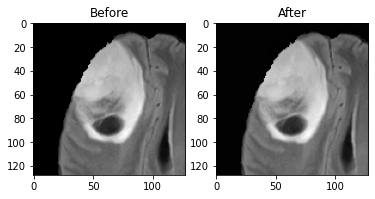

In [ ]:
fig, (ax1 , ax2) = plt.subplots(1, 2)
ax1.set_title('Before')
ax2.set_title('After')
ax1.imshow(sitk.GetArrayViewFromImage(croped_img)[64,:,:], cmap='gray')
ax2.imshow(sitk.GetArrayViewFromImage(bias_corrected_img)[64,:,:], cmap='gray')